In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energyuse/energydata.csv


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim



In [3]:
df = pd.read_csv("/kaggle/input/energyuse/energydata.csv",sep=',', header=0,
    na_values=['n/a'], index_col=0,)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 1/11/16 17:00 to 5/27/16 18:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ENERGY USE (WH)                              19735 non-null  int64  
 1   ENERGY USE OF LIGHT FIXTURES (WH)            19735 non-null  int64  
 2   TEMP IN KITCHEN (¡C)                         19735 non-null  float64
 3   HUMIDITY IN KITCHEN (IN %)                   19735 non-null  float64
 4   TEMP IN LIVING ROOM (¡C)                     19735 non-null  float64
 5   HUMIDITY IN LIVING ROOM (IN %)               19735 non-null  float64
 6   TEMP IN LAUNDRY ROOM (¡C)                    19735 non-null  float64
 7   HUMIDITY IN LAUNDRY ROOM (IN %)              19735 non-null  float64
 8   TEMP IN OFFICE ROOM (¡C)                     19735 non-null  float64
 9   HUMIDITY IN OFFICE ROOM (IN %)               19735 non-nu

,ENERGY USE (WH),ENERGY USE OF LIGHT FIXTURES (WH),TEMP IN KITCHEN (¡C),HUMIDITY IN KITCHEN (IN %),TEMP IN LIVING ROOM (¡C),HUMIDITY IN LIVING ROOM (IN %),TEMP IN LAUNDRY ROOM (¡C),HUMIDITY IN LAUNDRY ROOM (IN %),TEMP IN OFFICE ROOM (¡C),HUMIDITY IN OFFICE ROOM (IN %),...,TEMP IN PARENTS ROOM (¡C),HUMIDITY IN PARENTS ROOM (IN %),TEMP OUTSIDE (¡C),PRESSURE IN mmHg,HUMIDITY OUTSIDE (IN %),WINDSPEED IN M/S,VISIBILITY IN KM,TDEWPOINT IN CELSIUS,RANDOM VARIABLE 1,RANDOM VARIABLE 2
DATE,,,,,,,,,,,,,,,,,,,,,
1/11/16 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1/11/16 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
1/11/16 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
1/11/16 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
1/11/16 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
df = df.loc['1/12/16 00:00':'5/26/16 23:50']
df.shape

(19584, 28)

<Axes: xlabel='DATE'>

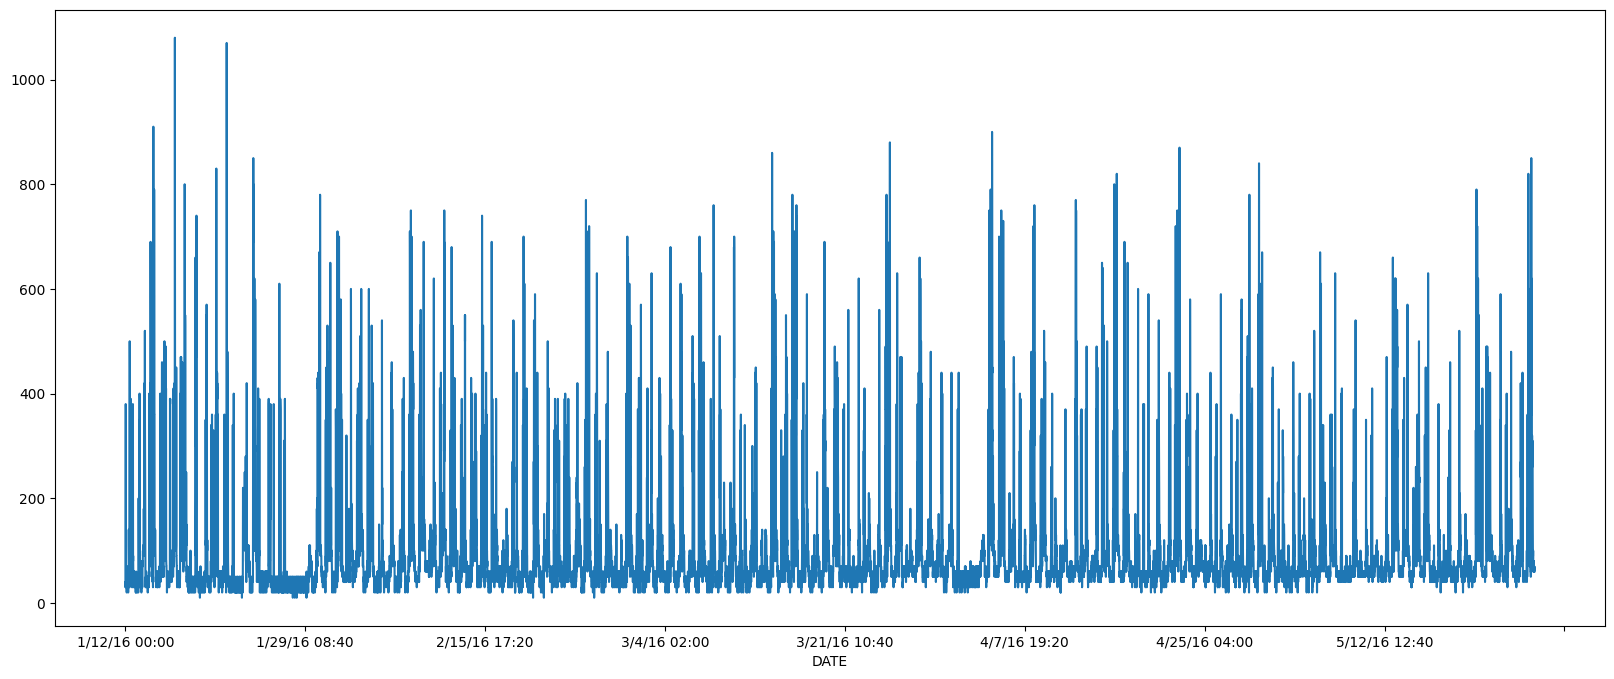

In [5]:
df['ENERGY USE (WH)'].plot(kind="line",figsize=(20,8))

In [6]:
df_train = df.loc['1/12/16 00:00':'4/28/16 23:50']
df_train.shape

(15552, 28)

In [7]:
df_test = df.loc['4/29/16 00:00':'5/26/16 23:50']
df_test.shape

(4032, 28)

In [8]:
#test-train ratio looks good
15552/(4032+15552)

0.7941176470588235

In [9]:
# Model using a sequence
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

model = nn.Sequential(
    LSTMLayer(input_size=1, hidden_size=128),
    nn.Dropout(p=0.2),
    nn.Flatten(),
    nn.Linear(128*6, 4),
    nn.Sigmoid()
)